In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import json
import enum

from col_mnist import ColMNIST
from three_d_shapes_ds import ThreeDShapes
from models import compute_layer_blocks_out


class SupportedDatasets(enum.Enum):
    THREEDSHAPES = 0,
    COL_MNIST = 1,
    CIFAR10 = 2

In [2]:
#vgg16 = torch.load("outputs/28.09.2021(14:21:35)/model.pt") #Col MNIST model
#vgg16 = torch.load("outputs/29.09.2021(16:00:55)/model.pt") #CIFAR
#vgg16 = torch.load("outputs/30.09.2021(14:12:14)/model.pt") #3DSHAPES filtered smaller layer
#vgg16 = torch.load("outputs/30.09.2021(14:24:53)/model.pt") #3DSHAPES filtered bigger layer
vgg16 = torch.load("outputs/01.10.2021(07:46:36)/model.pt")
layer = vgg16.classifier[0]
layer_size = layer.out_features
ncc = vgg16.classifier[2].n_conn_comp
blocks = compute_layer_blocks_out(layer, ncc)
ds = SupportedDatasets.THREEDSHAPES
filtered = False

In [3]:
if ds == SupportedDatasets.THREEDSHAPES:
    trainloader = torch.utils.data.DataLoader(
                                          ThreeDShapes(filename='data/3dshapes.h5',
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToPILImage(), 
                                                           torchvision.transforms.Resize((32, 32)),
                                                           torchvision.transforms.ToTensor(),
                                          ]), filtered = filtered),
                                          batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader(
                                          ThreeDShapes(filename='data/3dshapes.h5',
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToPILImage(), 
                                                           torchvision.transforms.Resize((32, 32)),
                                                           torchvision.transforms.ToTensor(),
                                          ]), filtered = filtered),
                                          batch_size=32, shuffle=True)
elif ds == SupportedDatasets.COL_MNIST:
    trainloader = torch.utils.data.DataLoader(
      ColMNIST('data/mnist', train=True, download=True,
                                 transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                                   torchvision.transforms.ToTensor(),
                                 ])),
      batch_size=32, shuffle=True)

    testloader = torch.utils.data.DataLoader(
      ColMNIST('data/mnist', train=False, download=True,
                                 transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                                   torchvision.transforms.ToTensor()
                                 ])),
      batch_size=32, shuffle=True)

elif ds == SupportedDatasets.CIFAR10:
    transform = transforms.Compose(
        [transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True)
    testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                            shuffle=False)
    n_classes = 10
    def target_vec_to_class(x):
        return x

In [4]:
#find activations for images
class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
layer.register_forward_hook(hook)
act = np.zeros((0, layer_size))

for i, data in enumerate(testloader):
    data, target = data[0], data[1]
    data = data.cuda()
    output = vgg16(data)
    act = np.concatenate((act, hook.outputs), axis=0)
    if i > 100:
        break
    
img_shape = data[0].shape
target_shape = target[0].shape

In [5]:
target_shape

torch.Size([6])

In [6]:
thr_low = np.percentile(act, 5, axis=0)
thr_high = np.percentile(act, 95, axis=0)

In [7]:
%pdb on

Automatic pdb calling has been turned ON


In [8]:
#find activations for images
class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
layer.register_forward_hook(hook)

weighted_images_pos = np.zeros((layer_size, *img_shape))
weighted_images_neg = np.zeros((layer_size, *img_shape))
targets_pos = [np.zeros((0, *target_shape)) for i in range(layer_size)]
targets_neg = [np.zeros((0, *target_shape)) for i in range(layer_size)]
n_pos = np.zeros((layer_size))
n_neg = np.zeros((layer_size))

for i, data in enumerate(testloader):
    print(i, end="\r")
    if i > 100:
        break
    data, target = data[0], data[1]
    data = data.cuda()
    output = vgg16(data)
    data = data.detach().cpu().numpy()

    batch_ext = np.repeat(data[:, np.newaxis, :, :], layer_size, axis=1)
    
    #print(weighted_images_pos.shape)
    #print(batch_ext.shape)
    weighted_images_pos += np.average(batch_ext * np.expand_dims((hook.outputs > thr_high), axis=(2, 3, 4)), axis=0)
    weighted_images_neg += np.average(batch_ext * np.expand_dims((hook.outputs < thr_low), axis=(2, 3, 4)), axis=0)
    n_pos += (hook.outputs > thr_high).sum(axis=0)/32
    n_neg += (hook.outputs < thr_low).sum(axis=0)/32
    
    #targets of images that activated each neuron by more than the threshold
    for j in range(layer_size):
       #print(target[hook.outputs[:,j] > thr_high[j]].shape)
       targets_pos[j] = np.concatenate([targets_pos[j], target[hook.outputs[:,j] > thr_high[j]]], axis=0)
       targets_neg[j] = np.concatenate([targets_neg[j], target[hook.outputs[:,j] < thr_low[j]]], axis=0)


In [9]:
#weighted_images_pos_norm = weighted_images_pos / np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
#weighted_images_neg_norm = weighted_images_neg / np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))
weighted_images_pos_norm = weighted_images_pos/n_pos[:, np.newaxis, np.newaxis, np.newaxis]
weighted_images_neg_norm = weighted_images_neg/n_neg[:, np.newaxis, np.newaxis, np.newaxis]

/tmp/ipykernel_18973/338085884.py:3: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_pos_norm = weighted_images_pos/n_pos[:, np.newaxis, np.newaxis, np.newaxis]
/tmp/ipykernel_18973/338085884.py:4: RuntimeWarning: invalid value encountered in true_divide
  weighted_images_neg_norm = weighted_images_neg/n_neg[:, np.newaxis, np.newaxis, np.newaxis]


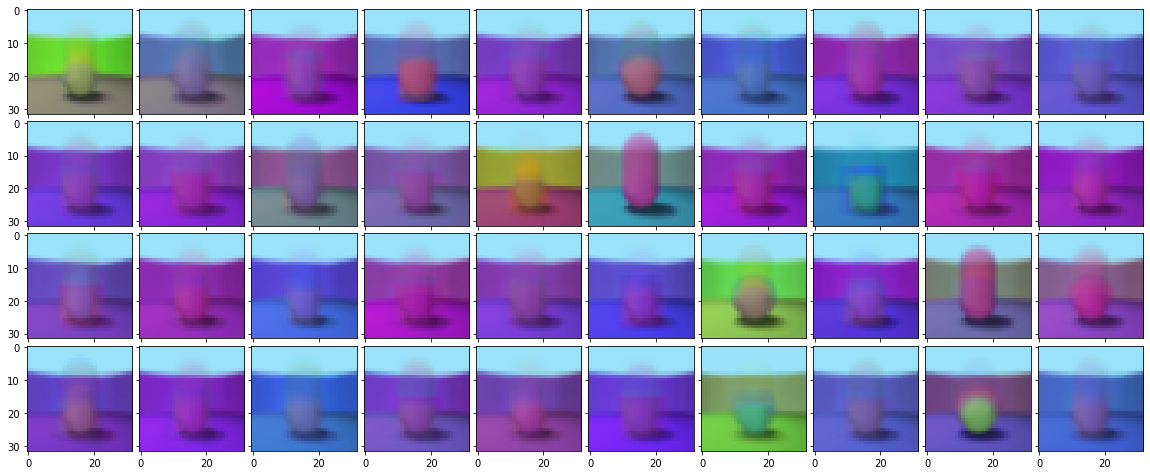

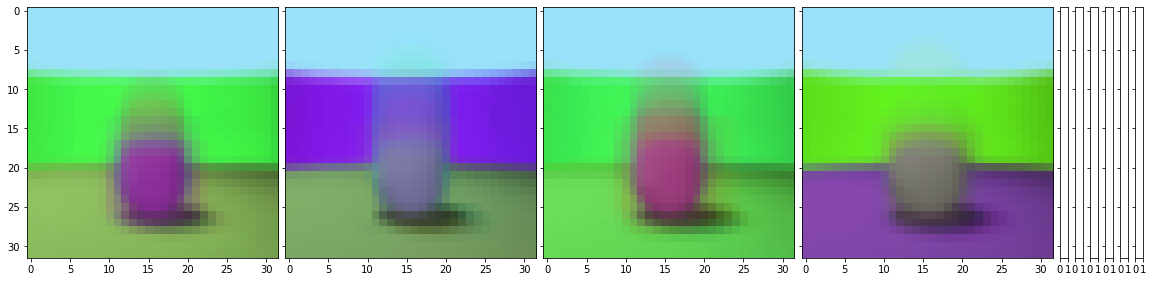

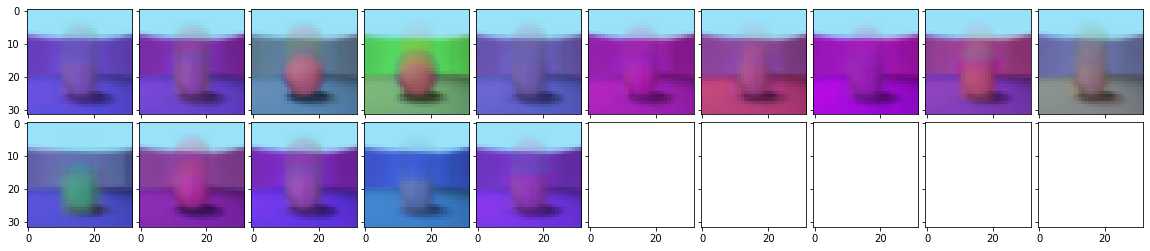

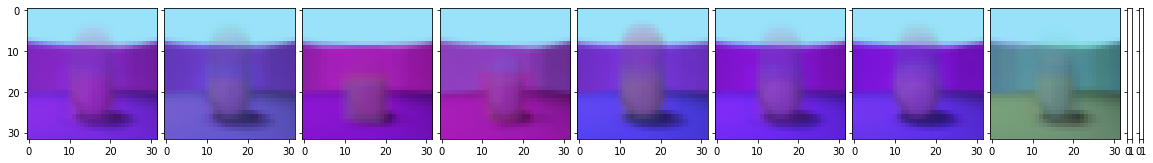

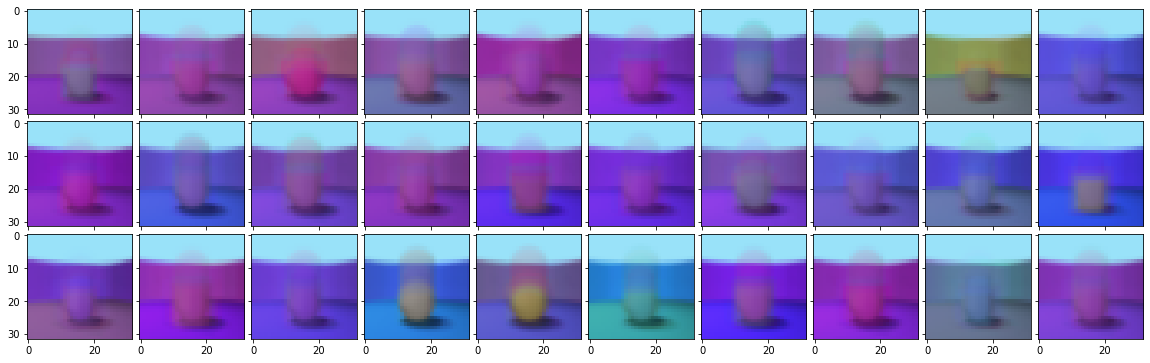

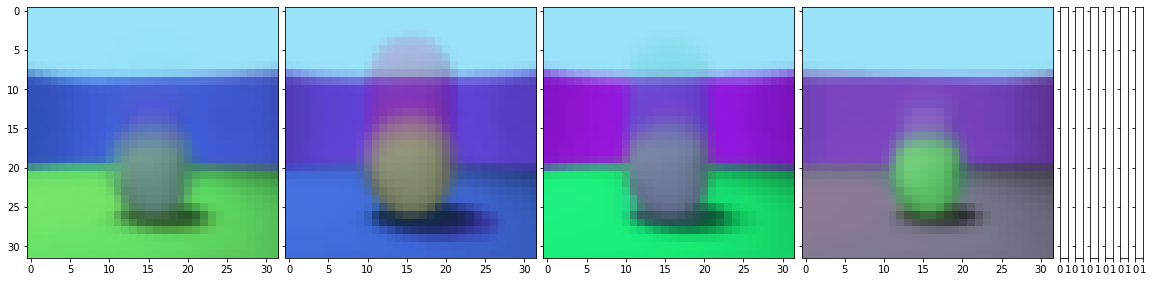

In [10]:
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
                     
    for ax, im in zip(grid, weighted_images_pos_norm[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))
    plt.show()
    
    targets_pos_aggregate = np.zeros((0, *target_shape))
    for i in range(layer_size):
       if blocks[i] == c:
           targets_pos_aggregate = np.concatenate([targets_pos_aggregate, targets_pos[i]], axis=0)
            
    #for i in range(6):
    #   plt.hist(targets_pos_aggregate[:, i])
    #   plt.show()
    
    grid_h = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(6, 1),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                   )
                     
    for ax, h in zip(grid_h, np.swapaxes(targets_pos_aggregate, 1, 0)):
        ax.hist(h)
    plt.show()

floor_hue


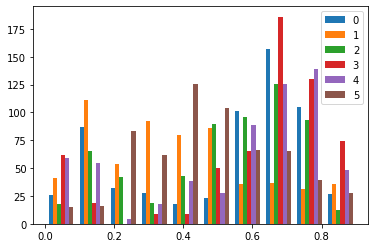

wall_hue


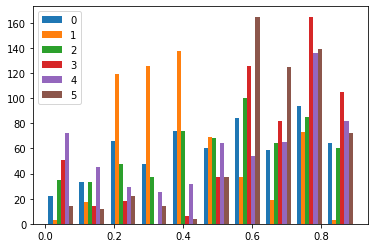

object_hue


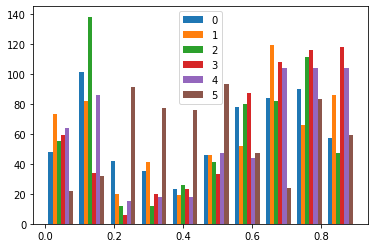

scale


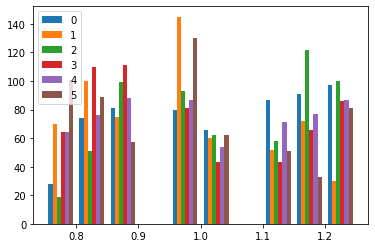

shape


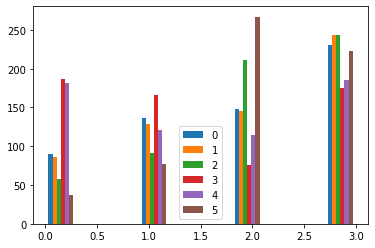

orientation


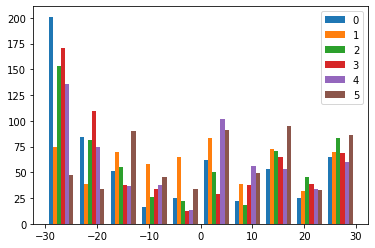

In [11]:
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']

for i in range(6):
    print(_FACTORS_IN_ORDER[i])
    targets_pos_aggregate = list()
    for c in range(ncc):
        #print("Block {}".format(c+1))
        targets_pos_aggregate.append(np.zeros((0)))
        for j in range(layer_size):
            if blocks[j] == c:
                targets_pos_aggregate[c] = np.concatenate([targets_pos_aggregate[c], targets_pos[j][:, i]], axis=0)

    #print(targets_pos_aggregate)
    min_len = min(len(targets_pos_aggregate[c]) for c in range(ncc))
    targets_pos_aggregate_sample = [targets_pos_aggregate[c][:min_len] for c in range(ncc)]
    plt.hist(np.array(targets_pos_aggregate_sample).transpose())
    plt.legend(range(ncc))
    plt.show()

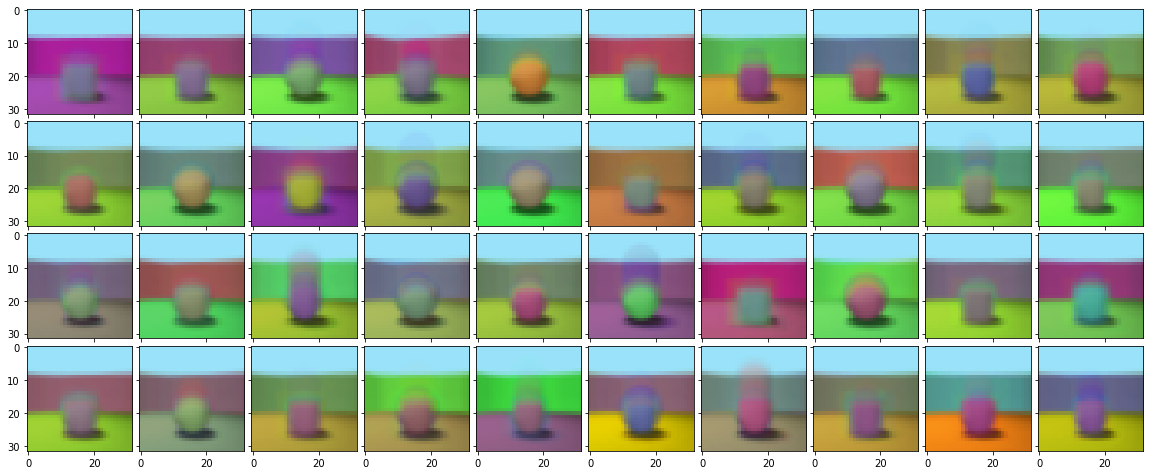

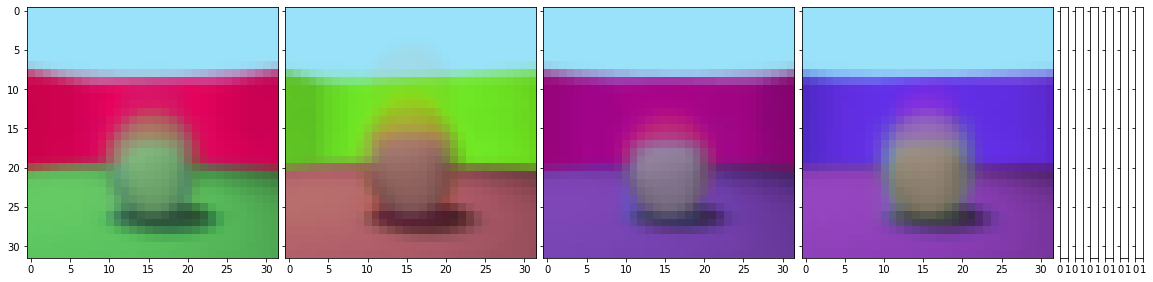

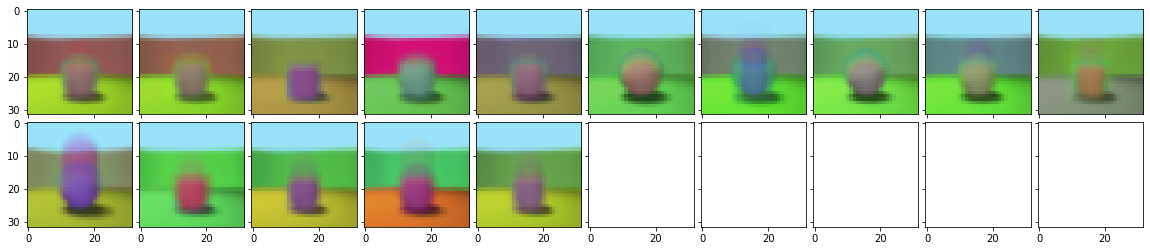

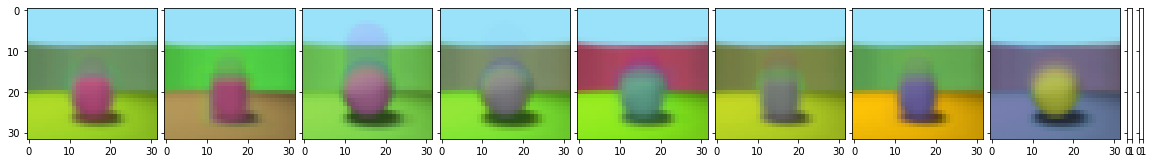

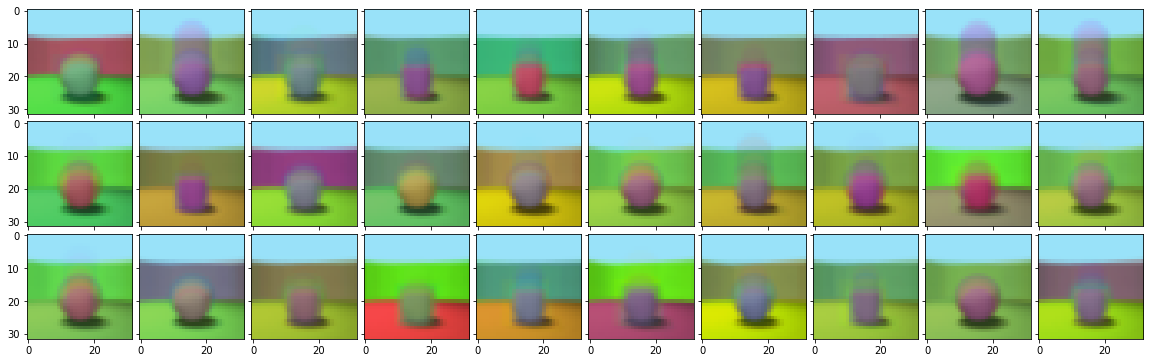

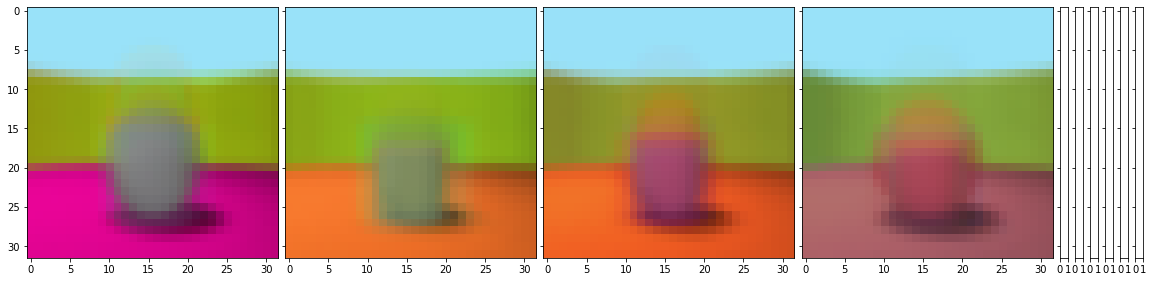

In [12]:
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    
    for ax, im in zip(grid, weighted_images_neg_norm[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))

In [13]:
n_classes = 8

# 0: floor_hue, 1: wall_hue, 2: object_hue, 3: scale, 4: shape, 5: orientation
#warmer colors: cyan, green, yellow, orange, red
#cooler colors: magenta, violet, blue

def target_vec_to_class(vec):
    labels = torch.zeros((vec.shape[0]))
    for i, v in enumerate(vec):
        if v[2] > 0.5: #object hue
            if v[0] > 0.5: #floor hue
                if v[5] > 0: #orientation
                    labels[i] = 7 #object of cooler color, cooler floor, orientation?
                else: #orientation
                    labels[i] = 6 #object of cooler color, cooler floor, orientation?
            else: #floor hue
                if v[4] > 1: #shape 
                    labels[i] = 5 #object of cooler color, warmer floor, pill or sphere
                else: #shape
                    labels[i] = 4 #object of cooler color, warmer floor, cylinder or cube
        else: #object hue
            if v[1] > 0.5: #wall hue
                if v[3] > 1: #scale
                    labels[i] = 3 #object of warmer color, cooler walls, bigger scale
                else: #scale
                    labels[i] = 2 #object of warmer color, cooler walls, smaller scale
            else:
                if v[4] > 2: #shape
                    labels[i] = 1 #object of warmer color, warmer walls, pill
                else: #shape
                    labels[i] = 0 #object of warmer color, warmer walls, sphere, cylinder or cube                   

    return labels.long()

In [14]:
target_examples = [np.zeros((0, *img_shape)) for i in range(n_classes)]
for i, data in enumerate(trainloader):
    data, target = data[0], data[1]
    target = target_vec_to_class(target)
    for j in range(n_classes):
        target_examples[j]= np.concatenate([target_examples[j], data[target==j]], axis=0)
    
    if min(te.shape[0] for te in target_examples) > 9:
        break

Class 0


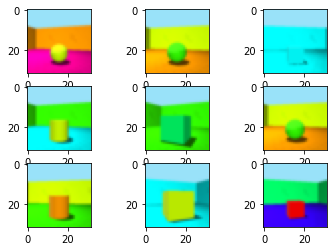

Class 1


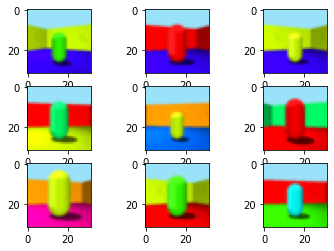

Class 2


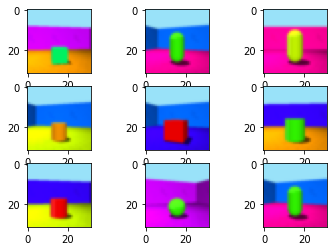

Class 3


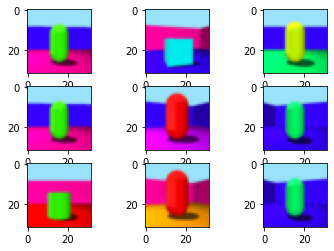

Class 4


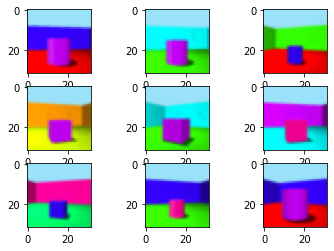

Class 5


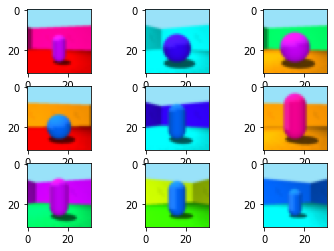

Class 6


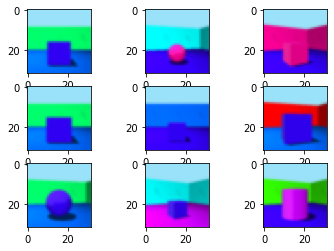

Class 7


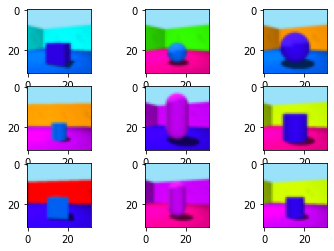

In [15]:
for j in range(n_classes):
    print("Class {}".format(j))
    fig, axs = plt.subplots(nrows=3, ncols=3)
    for ax, te in zip(axs.flatten(), target_examples[j][:9]):
        ax.imshow(te.transpose(1, 2, 0))
    plt.show()